/home/iiitd/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/iiitd/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


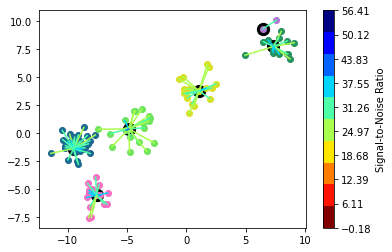

0.8026425838470459
{'Cluster Head': 'client1', 'Members': ['client95'], 'SNR': [26.465446832356843], 'CSI': [0.5320691555812347]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 5
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.01
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

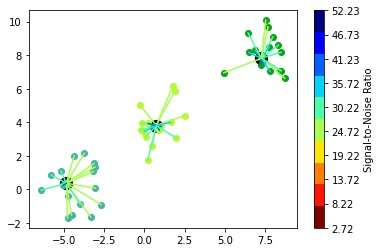

0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.400612


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/iiitd/.local/lib/python3.8/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.227787
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.742260
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.134516
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.067830

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268851
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.203762
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.408523
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.939655
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.085799

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.357026
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.163433
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.839221
Model client8 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.538424
Model client8 Train Epoch: 5 [0/1216 (0%)]	Loss: 1

/tmp/ipykernel_688202/1497942811.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client40 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.088975
Model client40 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.282411
Model client40 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.830068
Model client40 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.175082

Power Allocated= 5.717547877224266
CSI= 0.7376870706972294
SNR= 31.947247637939167
Client: client41
Model client41 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.319998
Model client41 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259801
Model client41 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.543878
Model client41 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.955086
Model client41 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.369520

Power Allocated= 0
CSI= 0.10505497815783926
SNR= 36.16708057646156
Client: client43
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.012473997692931
CSI= 0.9428072112474561
SNR= 29.317309433054763
Client: client46
Model client46 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.324758
Model client46 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.215530
Model

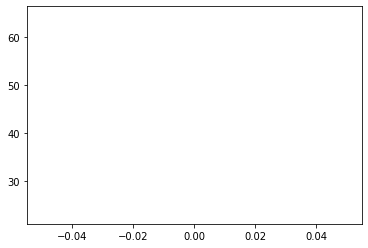

ROUND 0
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281108
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.036519
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.757167
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.239194
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.481400

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.319299
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.105994
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.692278
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.576952
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.823843

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295685
Model client8 Train Epoch: 2 [0/1216

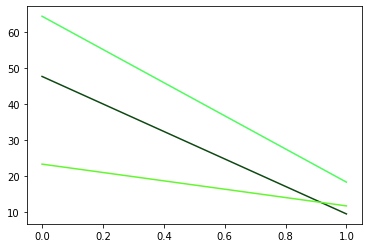

ROUND 1
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308181
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328880
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.202297
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.220563
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336517

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.315272
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.351495
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313047
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303090
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273178

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307425
Model client8 Train Epoch: 2 [0/1216

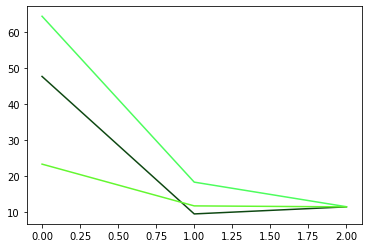

ROUND 2
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.317067
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290367
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289611
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316434
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325156

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303395
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313880
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302272
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.241259
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298767

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310632
Model client8 Train Epoch: 2 [0/1216

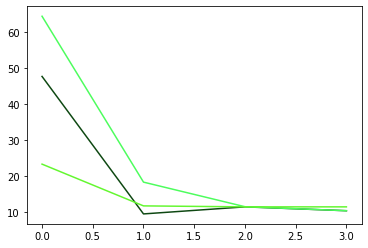

ROUND 3
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303777
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289694
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276078
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300599
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281658

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293879
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293565
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.276825
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306695
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306266

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305124
Model client8 Train Epoch: 2 [0/1216

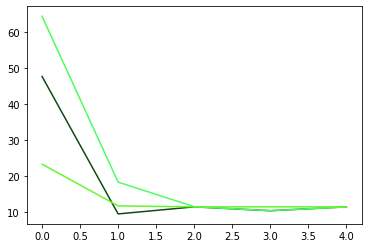

ROUND 4
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288716
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305341
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310669
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283839
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316417

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307431
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298056
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293839
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326358
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.249230

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305258
Model client8 Train Epoch: 2 [0/1216

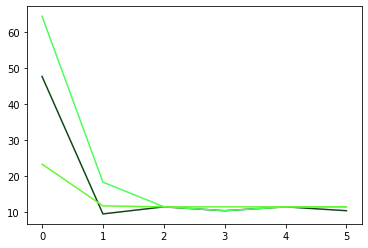

ROUND 5
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306422
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298988
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310334
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295846
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317888

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301722
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307711
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333268
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329738
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281863

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301153
Model client8 Train Epoch: 2 [0/1216

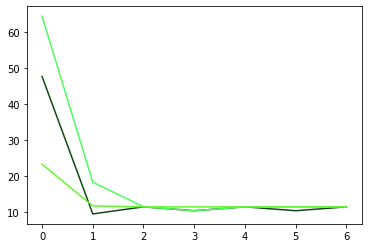

ROUND 6
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294850
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315015
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.271497
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.267553
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318075

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301077
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302535
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318905
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315951
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288762

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302574
Model client8 Train Epoch: 2 [0/1216

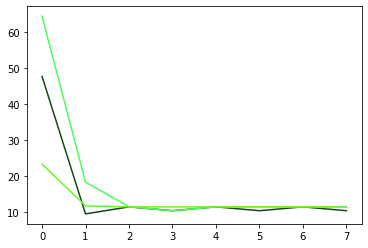

ROUND 7
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297054
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302748
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302515
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300709
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296501

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296273
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295797
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261524
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310816
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307636

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302626
Model client8 Train Epoch: 2 [0/1216

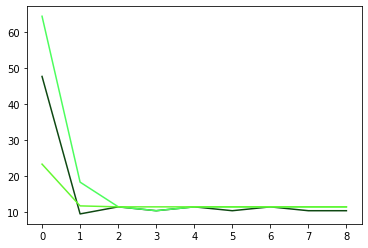

ROUND 8
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292659
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282667
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291206
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304201
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311971

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291739
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303734
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277548
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310710
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296823

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300885
Model client8 Train Epoch: 2 [0/1216

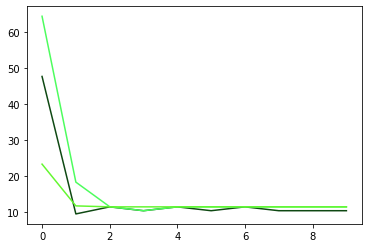

ROUND 9
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301968
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305372
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324406
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302905
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291374

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302009
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293846
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289250
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290138
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322866

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301946
Model client8 Train Epoch: 2 [0/1216

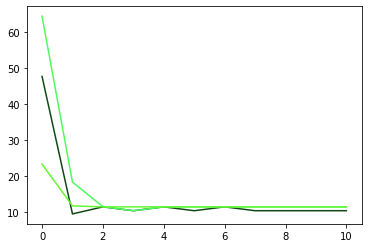

ROUND 10
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301387
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294458
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296544
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312372
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291691

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306587
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290219
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303213
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346859
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322274

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305738
Model client8 Train Epoch: 2 [0/121

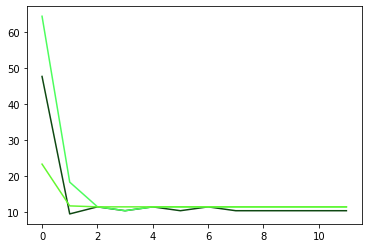

ROUND 11
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300123
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303449
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277281
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288950
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312115

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302386
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294776
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295714
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289439
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.269640

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300568
Model client8 Train Epoch: 2 [0/121

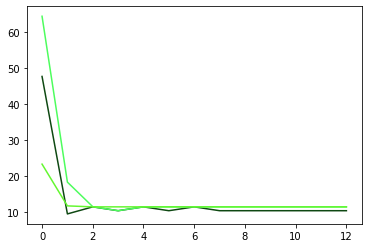

ROUND 12
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302412
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294455
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280657
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336981
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285406

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305950
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310628
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288939
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312247
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295513

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304342
Model client8 Train Epoch: 2 [0/121

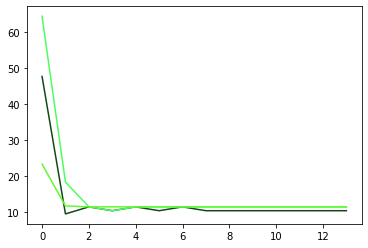

ROUND 13
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304631
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303166
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310299
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287863
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304434

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302296
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288848
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304607
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.279765
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283516

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299562
Model client8 Train Epoch: 2 [0/121

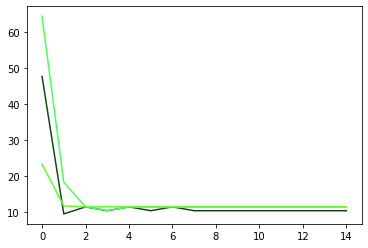

ROUND 14
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302481
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296987
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308235
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305578
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292297

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299650
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.316697
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.270173
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.253055
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308521

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303250
Model client8 Train Epoch: 2 [0/121

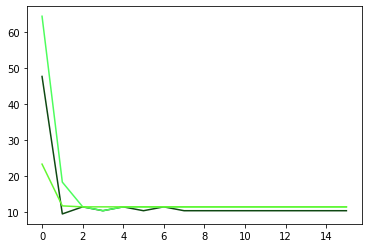

ROUND 15
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300712
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304382
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317831
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288494
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299676

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307412
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305656
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.275854
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297831
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321783

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300845
Model client8 Train Epoch: 2 [0/121

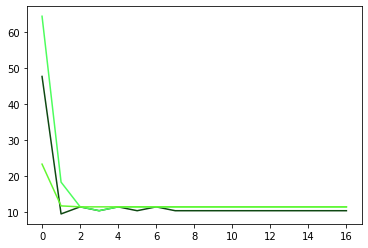

ROUND 16
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299614
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295771
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301592
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309119
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317790

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305783
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295594
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315165
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312778
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.283181

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301020
Model client8 Train Epoch: 2 [0/121

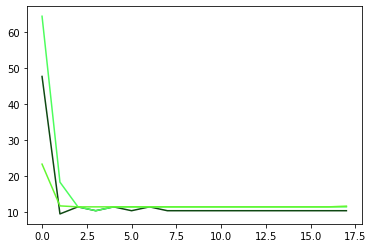

ROUND 17
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292459
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310116
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299182
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301385
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300404

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294272
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300874
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.352303
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318084
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337910

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295490
Model client8 Train Epoch: 2 [0/121

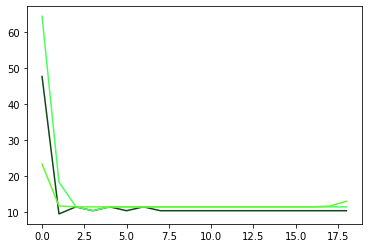

ROUND 18
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303889
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299567
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288666
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293911
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289058

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310178
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311729
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289859
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294596
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315455

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303289
Model client8 Train Epoch: 2 [0/121

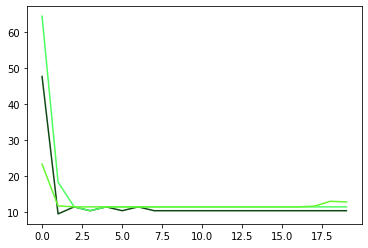

ROUND 19
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296779
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312652
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306349
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306955
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320048

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313663
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280575
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284576
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290179
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289106

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304333
Model client8 Train Epoch: 2 [0/121

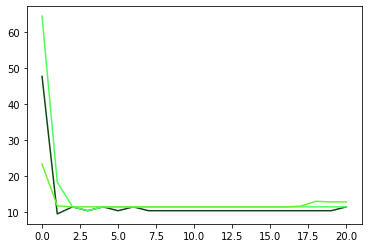

ROUND 20
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294747
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297834
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319844
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286585
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288820

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298550
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298918
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285748
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322835
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346141

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310152
Model client8 Train Epoch: 2 [0/121

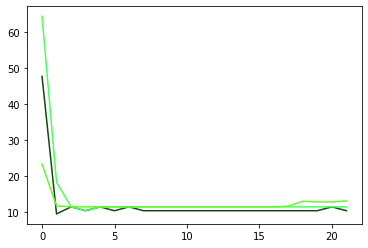

ROUND 21
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302941
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301439
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306987
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.273841
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276643

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296979
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304579
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307782
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289114
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317004

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308724
Model client8 Train Epoch: 2 [0/121

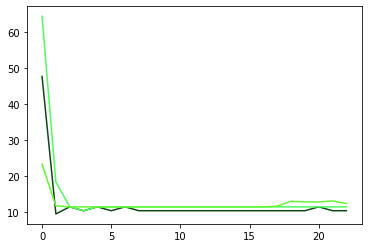

ROUND 22
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308309
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321723
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306672
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292039
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315276

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307531
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296925
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296638
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.266110
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.284384

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293782
Model client8 Train Epoch: 2 [0/121

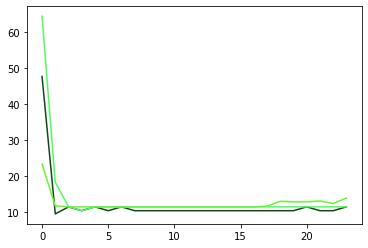

ROUND 23
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294333
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302460
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339036
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317430
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313046

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298360
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307789
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302665
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287670
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279881

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307428
Model client8 Train Epoch: 2 [0/121

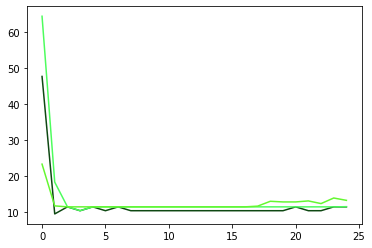

ROUND 24
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302101
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.270240
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310039
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327848
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313620

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304475
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305054
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288602
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329221
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273929

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297379
Model client8 Train Epoch: 2 [0/121

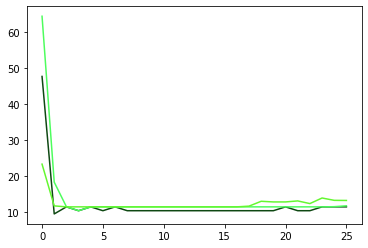

ROUND 25
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306107
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313021
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301284
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299775
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316940

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300010
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287745
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299116
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299214
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288428

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302533
Model client8 Train Epoch: 2 [0/121

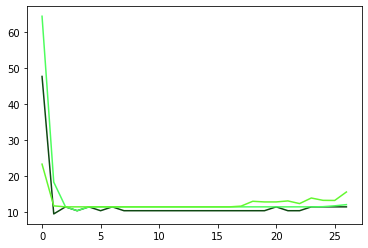

ROUND 26
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304333
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303141
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297975
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308634
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297449

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305516
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317640
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272437
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313744
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286866

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307174
Model client8 Train Epoch: 2 [0/121

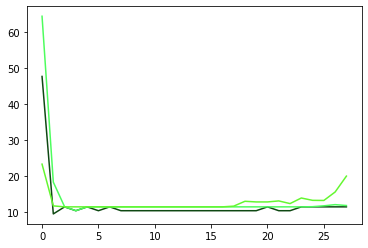

ROUND 27
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293933
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297561
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283022
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294450
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267231

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294041
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317237
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272880
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310533
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312909

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304949
Model client8 Train Epoch: 2 [0/121

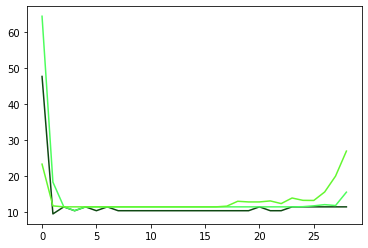

ROUND 28
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303214
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302701
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294545
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289893
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294230

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291061
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327393
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272575
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.262334
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341782

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307647
Model client8 Train Epoch: 2 [0/121

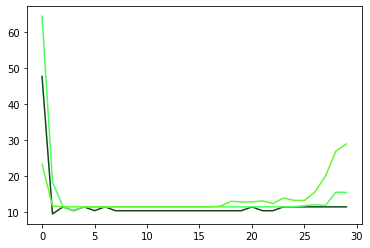

ROUND 29
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290921
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317930
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281713
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280867
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298331

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303274
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280282
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.245572
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.213067
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.251267

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300891
Model client8 Train Epoch: 2 [0/121

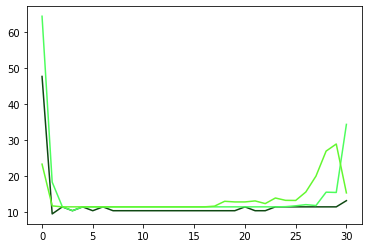

ROUND 30
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276153
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296125
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.213413
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.246337
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.234490

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312476
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291792
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.315283
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328092
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285605

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295479
Model client8 Train Epoch: 2 [0/121

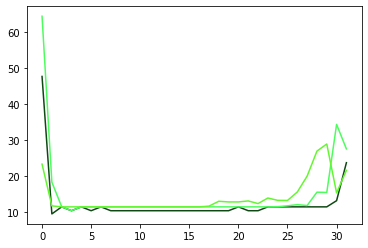

ROUND 31
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281193
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.117371
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.938672
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.246898
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318536

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.237616
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290933
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.269999
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312277
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.259356

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.136726
Model client8 Train Epoch: 2 [0/121

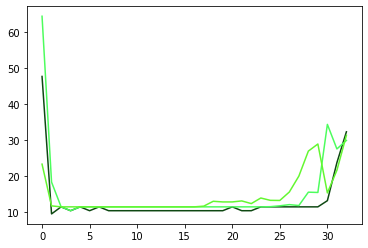

ROUND 32
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217354
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.009487
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.194570
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.385817
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300108

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.178306
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.233456
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306005
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.254163
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306606

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238524
Model client8 Train Epoch: 2 [0/121

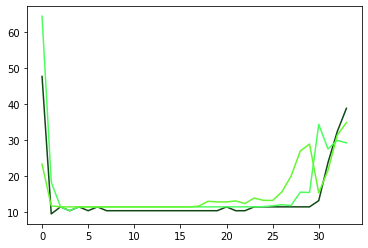

ROUND 33
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.127471
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.113167
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298487
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343994
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314962

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.044265
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.973986
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296194
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.428360
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319018

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213984
Model client8 Train Epoch: 2 [0/121

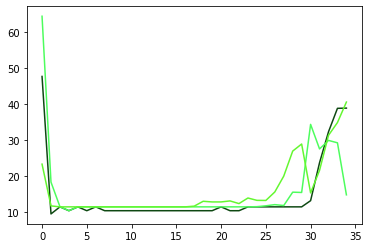

ROUND 34
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181093
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309440
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.319670
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303373
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307350

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200429
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299533
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290045
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295237
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297827

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166127
Model client8 Train Epoch: 2 [0/121

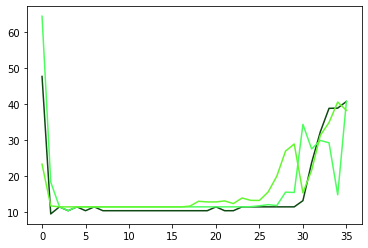

ROUND 35
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.198828
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.254381
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.270003
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308018
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328179

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.079205
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.163420
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.117090
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.376832
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299319

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.111736
Model client8 Train Epoch: 2 [0/121

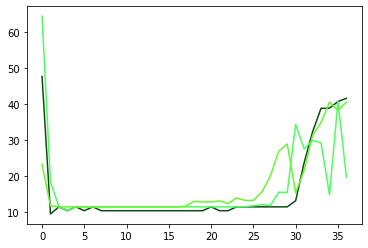

ROUND 36
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.048047
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291630
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317497
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.245207
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315834

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257644
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.973989
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.172311
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317286
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326805

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.046077
Model client8 Train Epoch: 2 [0/121

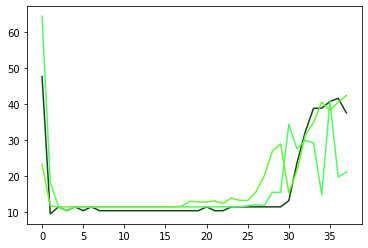

ROUND 37
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.051065
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.140030
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303373
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327987
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314535

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.117233
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297599
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330044
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.267303
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310870

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223742
Model client8 Train Epoch: 2 [0/121

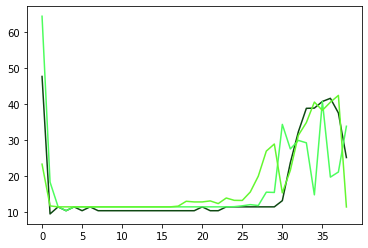

ROUND 38
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.343471
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.138288
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324548
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.157272
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310354

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286019
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.775027
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.273811
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301089
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303046

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.326502
Model client8 Train Epoch: 2 [0/121

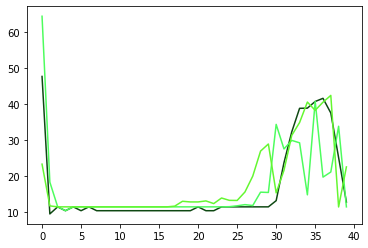

ROUND 39
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270488
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279379
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296470
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362706
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317135

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246298
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.254084
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.241663
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.203123
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290176

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240932
Model client8 Train Epoch: 2 [0/121

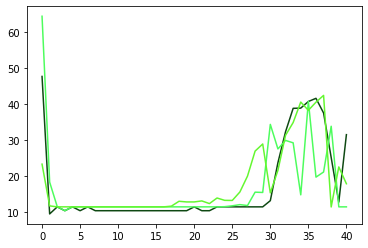

ROUND 40
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301383
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298638
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.233837
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291922
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286872

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268866
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304861
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303867
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290799
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295344

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290635
Model client8 Train Epoch: 2 [0/121

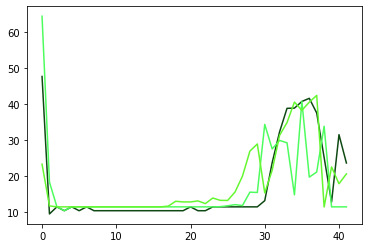

ROUND 41
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289159
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301553
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299412
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305642

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296154
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282328
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.216562
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.207230
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302981

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281912
Model client8 Train Epoch: 2 [0/121

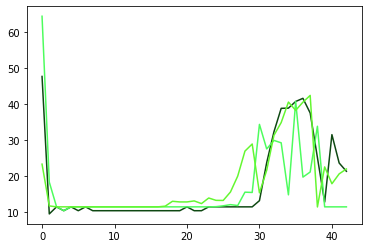

ROUND 42
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247132
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.171425
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302248
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360507
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.377727

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294189
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.168576
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.814108
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293044
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314356

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264033
Model client8 Train Epoch: 2 [0/121

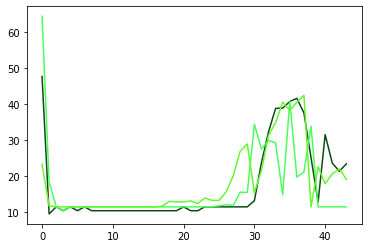

ROUND 43
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255290
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298447
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310319
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321519
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267759

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302098
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276053
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302125
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335913
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321416

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.234353
Model client8 Train Epoch: 2 [0/121

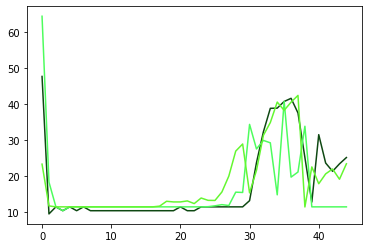

ROUND 44
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228440
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276901
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310510
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314164
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333261

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.186486
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.226789
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299113
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287738
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.341267

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.229437
Model client8 Train Epoch: 2 [0/121

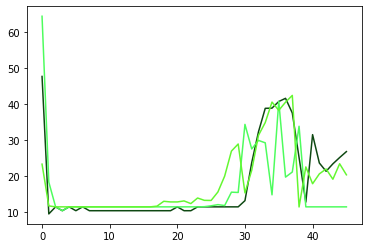

ROUND 45
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258561
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286987
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316334
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294777
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304269

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.222181
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301664
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327164
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275991
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304813

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196736
Model client8 Train Epoch: 2 [0/121

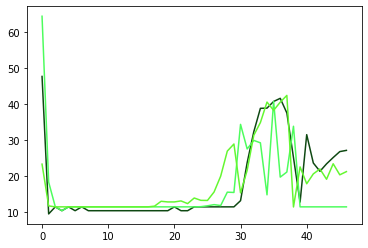

ROUND 46
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.255034
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.219073
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308999
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301967
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323228

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235798
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328017
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277136
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.270519
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307477

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233495
Model client8 Train Epoch: 2 [0/121

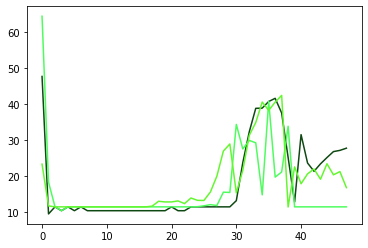

ROUND 47
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309313
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.235642
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314522
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275204
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306237

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272083
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.270116
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261657
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304954
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.223805

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256516
Model client8 Train Epoch: 2 [0/121

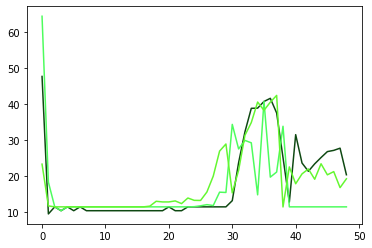

ROUND 48
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235535
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.169730
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.209180
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289660
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306209

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262901
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.224574
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280687
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317593
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316302

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268393
Model client8 Train Epoch: 2 [0/121

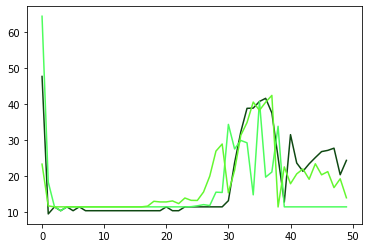

ROUND 49
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304713
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.092720
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.238611
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328423
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300957

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308038
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.228954
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.194418
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297468
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265828

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306883
Model client8 Train Epoch: 2 [0/121

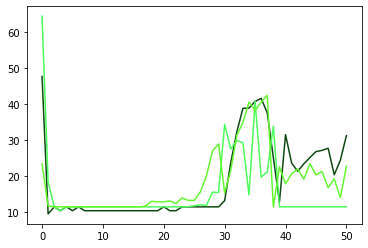

ROUND 50
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.191748
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.159051
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.255126
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331085
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273901

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.174408
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.133808
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.226698
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342108
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.255063

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227555
Model client8 Train Epoch: 2 [0/121

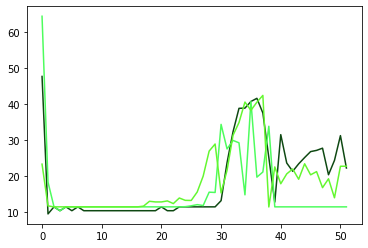

ROUND 51
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.234982
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.239726
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.265789
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296075
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293803

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.393421
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.159519
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290828
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339929
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.250216

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299687
Model client8 Train Epoch: 2 [0/121

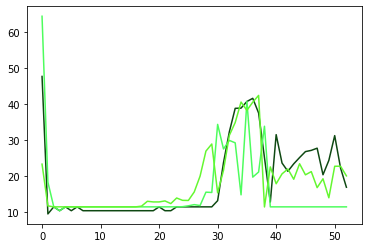

ROUND 52
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.224182
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.232475
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323195
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318408
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328519

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194451
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.150851
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.250409
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.128065
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 3.447662

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.233077
Model client8 Train Epoch: 2 [0/121

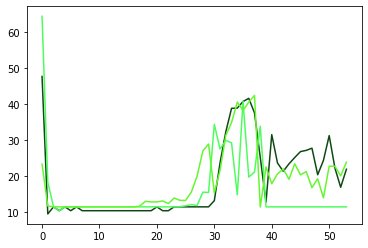

ROUND 53
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193568
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269917
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317119
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311252
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300275

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282840
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.747293
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297821
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.331790
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287357

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235973
Model client8 Train Epoch: 2 [0/121

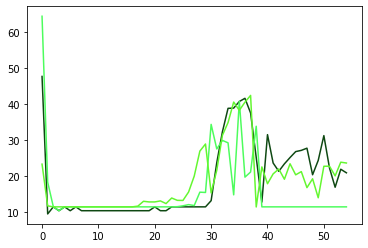

ROUND 54
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267616
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.135856
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288677
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.341280
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.351345

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213369
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301054
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314653
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308321
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305558

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267063
Model client8 Train Epoch: 2 [0/121

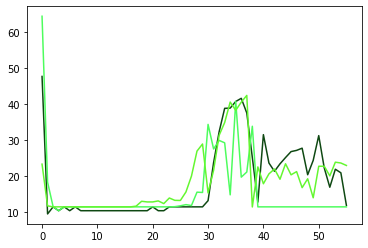

ROUND 55
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.168295
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264057
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.225780
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.195876
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286216

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.250124
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304651
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.273566
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.266952
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308359

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268055
Model client8 Train Epoch: 2 [0/121

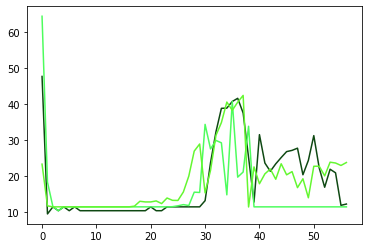

ROUND 56
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.284851
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.154742
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.128985
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.524036
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.138352

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262372
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308750
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301013
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.284428
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280049

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.382667
Model client8 Train Epoch: 2 [0/121

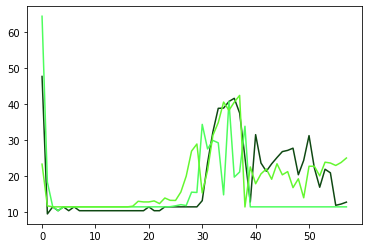

ROUND 57
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282315
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300302
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274832
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325733
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295410

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308923
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311971
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.252993
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306864
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313150

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.231324
Model client8 Train Epoch: 2 [0/121

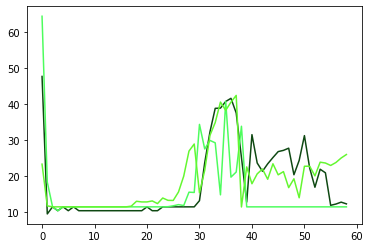

ROUND 58
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253213
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.226251
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312593
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301902
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290895

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195854
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319189
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299466
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282680
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.375904

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.153489
Model client8 Train Epoch: 2 [0/121

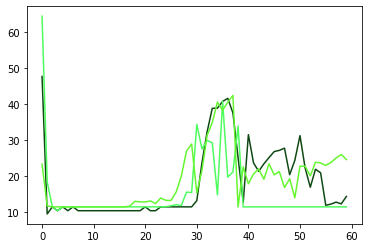

ROUND 59
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.222075
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.120142
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.284788
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.279905
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308519

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.171911
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286961
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318065
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297615
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302292

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.261514
Model client8 Train Epoch: 2 [0/121

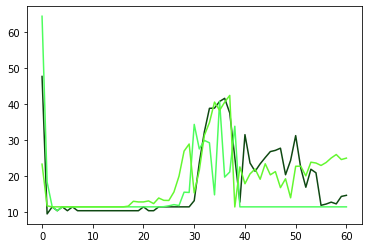

ROUND 60
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306475
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.215313
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.337586
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351102
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291445

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.187557
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305473
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300811
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319038
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.278169

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206871
Model client8 Train Epoch: 2 [0/121

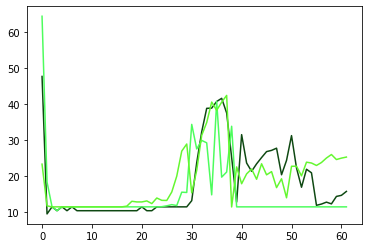

ROUND 61
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.147770
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.068173
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311082
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313386
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293655

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.077256
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297286
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294839
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282527
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346681

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221491
Model client8 Train Epoch: 2 [0/121

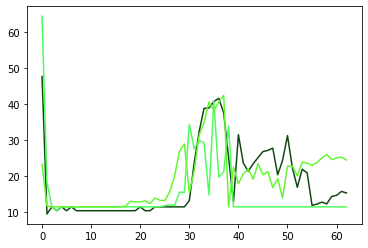

ROUND 62
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271959
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289009
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336511
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321261
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.321606

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182272
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300584
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296421
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304624
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.339563

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230828
Model client8 Train Epoch: 2 [0/121

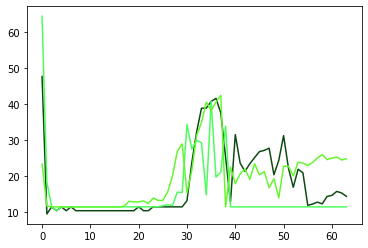

ROUND 63
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.154255
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264244
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328570
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298695
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275103

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.477059
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310286
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286590
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295826
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.350917

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293652
Model client8 Train Epoch: 2 [0/121

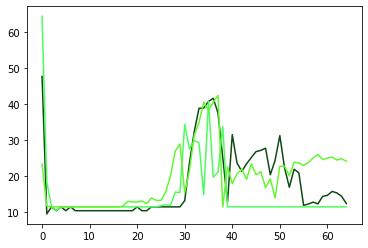

ROUND 64
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228011
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.206999
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.146171
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.221324
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.197534

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203595
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295513
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.279225
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345233
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326687

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223270
Model client8 Train Epoch: 2 [0/121

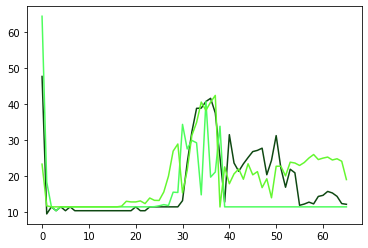

ROUND 65
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263274
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305484
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299696
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308003
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315980

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265481
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302753
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277455
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329149
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291572

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.332476
Model client8 Train Epoch: 2 [0/121

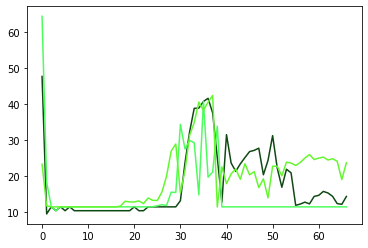

ROUND 66
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265616
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.271034
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277505
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297868
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344980

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194206
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306301
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300782
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.257851
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344778

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267503
Model client8 Train Epoch: 2 [0/121

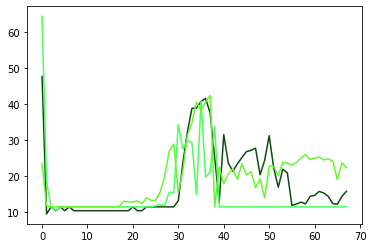

ROUND 67
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.193399
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.218580
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.119711
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.222896
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317218

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273464
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299304
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349386
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.267844
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318832

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.161997
Model client8 Train Epoch: 2 [0/121

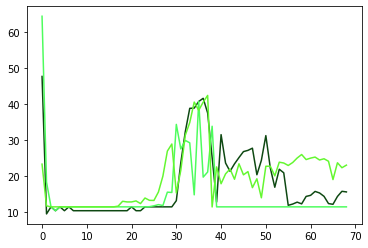

ROUND 68
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.087081
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.149176
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.160972
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312251
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291064

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.260694
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313084
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290670
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322984
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.347416

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.222733
Model client8 Train Epoch: 2 [0/121

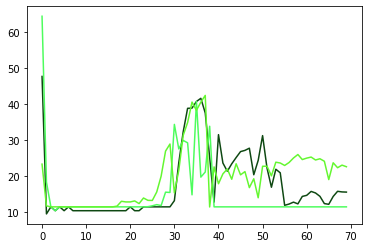

ROUND 69
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270092
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269984
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296891
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311177
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309570

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.184551
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300065
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298809
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317100
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301528

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.410234
Model client8 Train Epoch: 2 [0/121

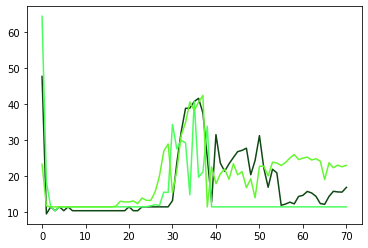

ROUND 70
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.182834
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.244036
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298047
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326683
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300257

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.107361
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282818
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339873
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301188
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296324

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166255
Model client8 Train Epoch: 2 [0/121

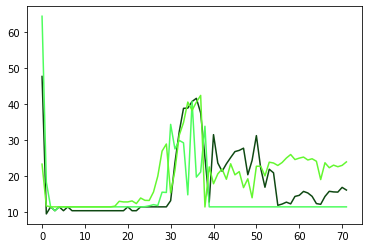

ROUND 71
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.139270
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.213625
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308450
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.322100
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307145

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.158091
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280819
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.267152
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.248444
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314259

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.087850
Model client8 Train Epoch: 2 [0/121

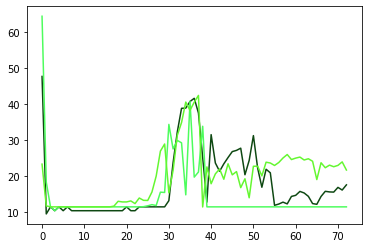

ROUND 72
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.199844
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310806
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344557
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.277228
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314150

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295067
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323100
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281088
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306829
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.272903

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.170925
Model client8 Train Epoch: 2 [0/121

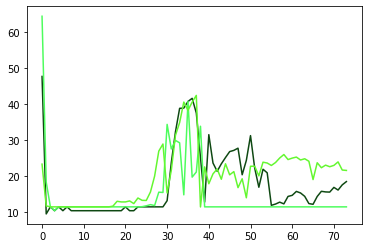

ROUND 73
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226877
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332836
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290437
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280968
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313835

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.208284
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.261588
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296756
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315588
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303496

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228253
Model client8 Train Epoch: 2 [0/121

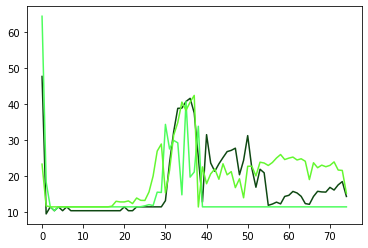

ROUND 74
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304473
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.273968
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322957
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307389
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291518

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269525
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320932
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274715
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301780
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281769

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228089
Model client8 Train Epoch: 2 [0/121

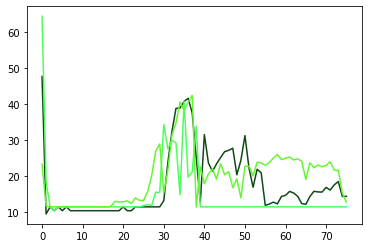

ROUND 75
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304432
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279772
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323739
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311949
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295400

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301682
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299419
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287570
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306256
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288195

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263800
Model client8 Train Epoch: 2 [0/121

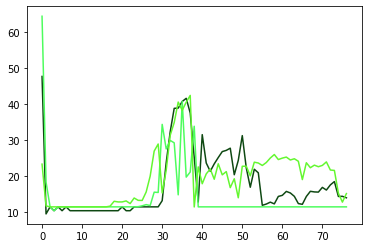

ROUND 76
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267664
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266640
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351473
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319282
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313114

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290098
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292000
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308046
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328783
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290510

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263929
Model client8 Train Epoch: 2 [0/121

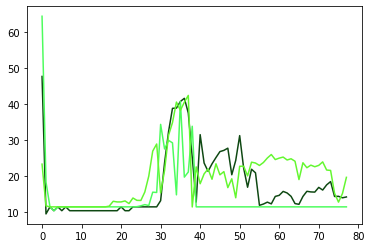

ROUND 77
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262029
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296153
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.289461
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300130
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308586

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296117
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300163
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330755
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.332533
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338640

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300432
Model client8 Train Epoch: 2 [0/121

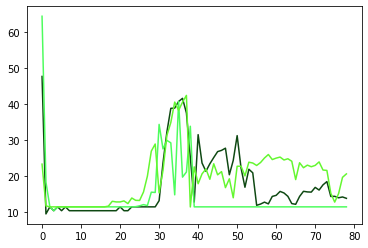

ROUND 78
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259104
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295238
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303730
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337265
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313555

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.213532
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300956
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297655
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280224
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277410

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259076
Model client8 Train Epoch: 2 [0/121

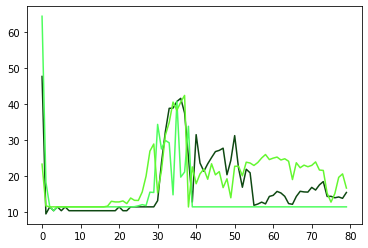

ROUND 79
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306280
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302511
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266881
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329228
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289003

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232421
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294164
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304287
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307681
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.258673

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263838
Model client8 Train Epoch: 2 [0/121

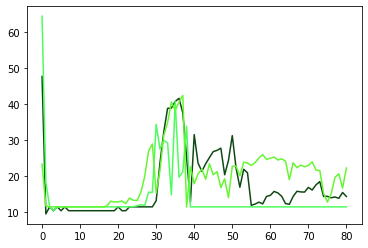

ROUND 80
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.180054
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289195
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316932
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317660
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282977

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.263543
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279184
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308418
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295045
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.263242

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258825
Model client8 Train Epoch: 2 [0/121

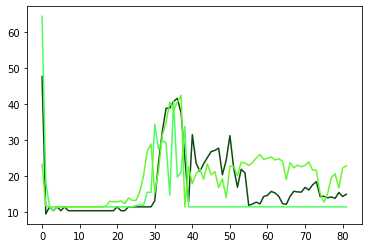

ROUND 81
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183721
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308224
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312346
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293481
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282046

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278531
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323537
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322652
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304846
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301570

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183329
Model client8 Train Epoch: 2 [0/121

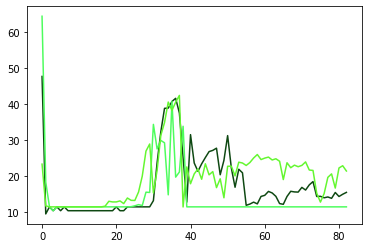

ROUND 82
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267219
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.188453
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299202
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.326762
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310532

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.277618
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318989
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294987
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301399
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289888

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.564483
Model client8 Train Epoch: 2 [0/121

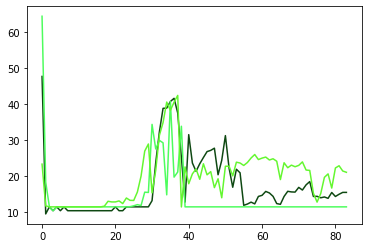

ROUND 83
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.191070
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.197008
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306660
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.301750
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298432

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235977
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294747
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308008
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319463
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334147

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295559
Model client8 Train Epoch: 2 [0/121

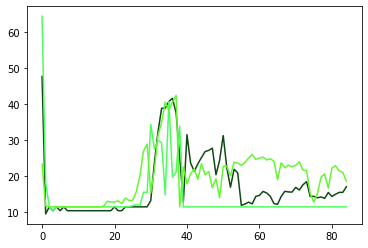

ROUND 84
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.242474
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.230747
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293450
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309637
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320514

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265722
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324084
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321258
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321895
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343982

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.269017
Model client8 Train Epoch: 2 [0/121

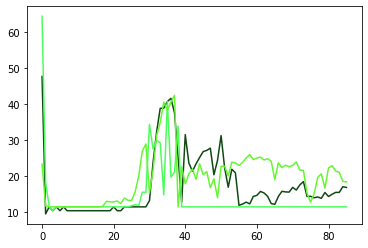

ROUND 85
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.120505
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.166043
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.258503
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319166
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.256149

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305474
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284200
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286940
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.262909
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299743

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.209633
Model client8 Train Epoch: 2 [0/121

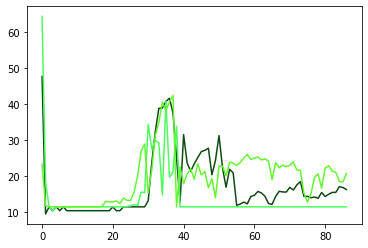

ROUND 86
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272447
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.443261
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.161149
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.382835
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.356910

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230178
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325906
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302385
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312047
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.263277

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.238319
Model client8 Train Epoch: 2 [0/121

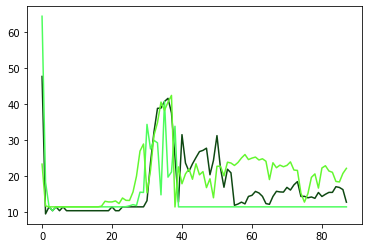

ROUND 87
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295227
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303565
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291424
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302128
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290846

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271742
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311564
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305358
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308719
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301045

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230804
Model client8 Train Epoch: 2 [0/121

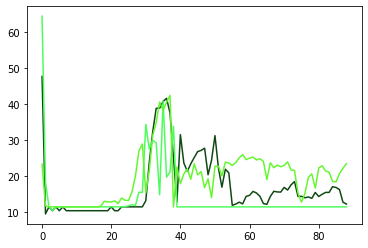

ROUND 88
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259588
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279132
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323818
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337560
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304445

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.125911
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301584
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283410
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323837
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330892

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298763
Model client8 Train Epoch: 2 [0/121

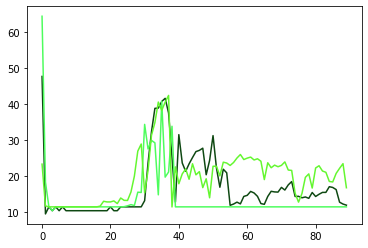

ROUND 89
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303746
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313576
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298030
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.253000
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273564

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160245
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279431
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321815
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367926
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340641

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276517
Model client8 Train Epoch: 2 [0/121

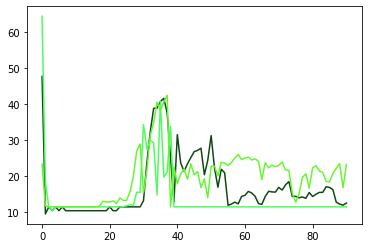

ROUND 90
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266054
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309226
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326626
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318553
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290503

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.373759
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325466
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328139
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295567
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285545

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.185976
Model client8 Train Epoch: 2 [0/121

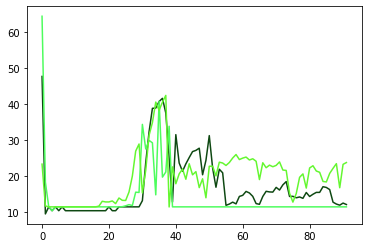

ROUND 91
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.121866
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315012
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303328
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295688
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296656

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.181358
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299338
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300023
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308228
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307441

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195307
Model client8 Train Epoch: 2 [0/121

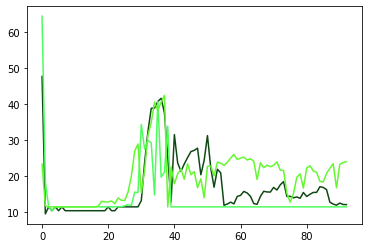

ROUND 92
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.179959
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292379
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.261801
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290771
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290200

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309389
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.264229
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.344751
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.258300
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337795

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.039356
Model client8 Train Epoch: 2 [0/121

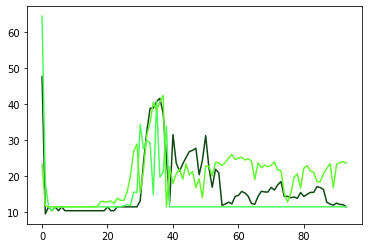

ROUND 93
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.160628
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307994
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280537
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329216
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327132

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.174443
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.326865
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331781
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305530
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.346897

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.126053
Model client8 Train Epoch: 2 [0/121

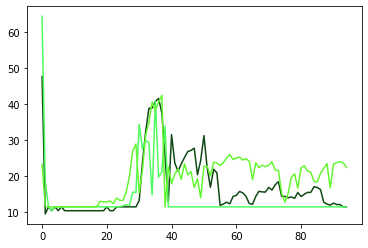

ROUND 94
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264286
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314793
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285022
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.270143
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300830

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248204
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305467
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314574
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316989
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311950

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.189444
Model client8 Train Epoch: 2 [0/121

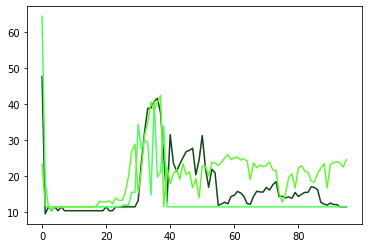

ROUND 95
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298419
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300808
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302490
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337097
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293649

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.158415
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315908
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307980
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.285124
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.259021

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.164381
Model client8 Train Epoch: 2 [0/121

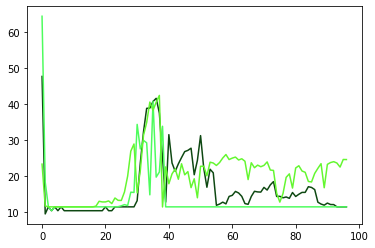

ROUND 96
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291763
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308498
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323076
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312560
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292072

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.135259
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.222829
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312136
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275609
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286073

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248205
Model client8 Train Epoch: 2 [0/121

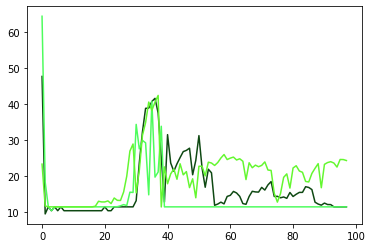

ROUND 97
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.260537
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284018
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335903
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.315871
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313914

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.139639
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305799
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318841
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321416
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313732

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.144012
Model client8 Train Epoch: 2 [0/121

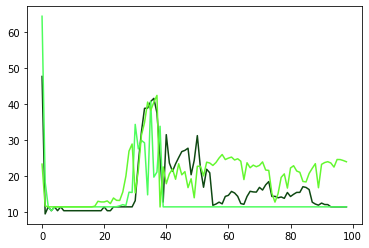

ROUND 98
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.225607
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319213
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311189
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.363422
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298491

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.156687
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306344
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292435
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314153
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265346

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.258574
Model client8 Train Epoch: 2 [0/121

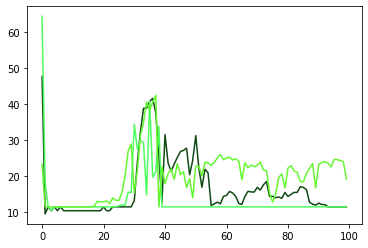

ROUND 99
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.264466
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305648
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.232966
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.362454
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315449

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295644
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317992
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314564
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.252074
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305720

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291020
Model client8 Train Epoch: 2 [0/121

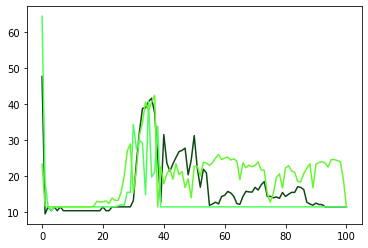

ROUND 100
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305589
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304872
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326280
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338090
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311964

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293003
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288775
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340777
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288522
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306396

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297674
Model client8 Train Epoch: 2 [0/12

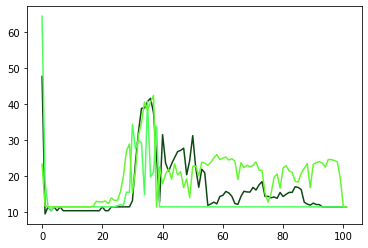

ROUND 101
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301690
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302798
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303617
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317890
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313485

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306179
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313669
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.363926
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295807
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.278020

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302562
Model client8 Train Epoch: 2 [0/12

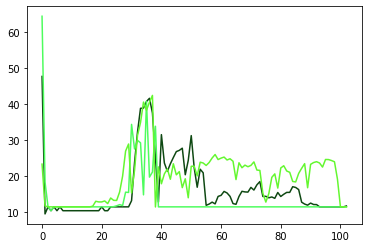

ROUND 102
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296658
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292106
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314969
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286415
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324194

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305128
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345299
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304462
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323652
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338713

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305776
Model client8 Train Epoch: 2 [0/12

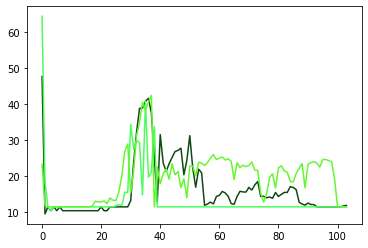

ROUND 103
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299336
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296392
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296212
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348321
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303807

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307281
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311171
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309885
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328345
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267885

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295727
Model client8 Train Epoch: 2 [0/12

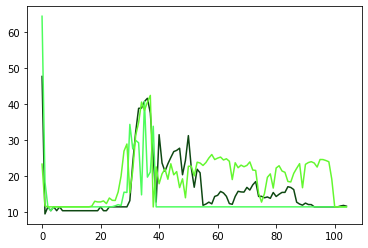

ROUND 104
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303519
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285527
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330262
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323947
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280880

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295354
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305882
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340183
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323993
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315149

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305479
Model client8 Train Epoch: 2 [0/12

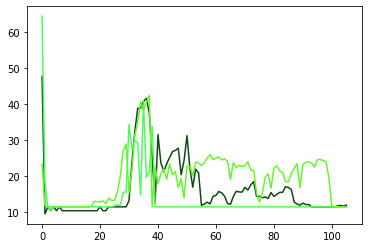

ROUND 105
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299926
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299956
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302419
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.305233
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.330052

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300700
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327012
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266101
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.252186
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306256

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298321
Model client8 Train Epoch: 2 [0/12

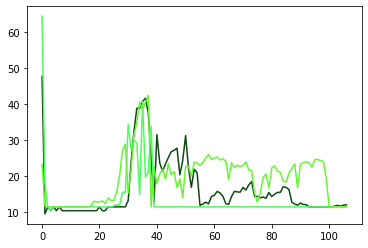

ROUND 106
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295527
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312831
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300800
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289149
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333139

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309261
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295623
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326292
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.371253
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273027

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298734
Model client8 Train Epoch: 2 [0/12

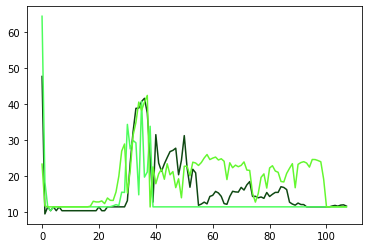

ROUND 107
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301302
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309206
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311504
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330259
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322622

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302922
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295166
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326072
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.278551
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285804

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307852
Model client8 Train Epoch: 2 [0/12

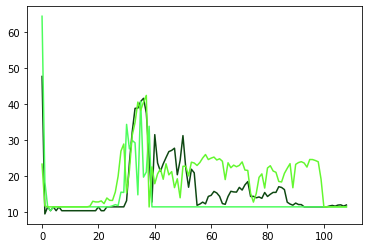

ROUND 108
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303547
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304081
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316564
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310758
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312742

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300146
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.331158
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309487
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289829
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.343325

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305203
Model client8 Train Epoch: 2 [0/12

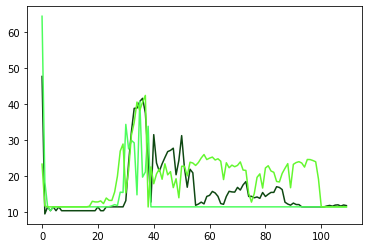

ROUND 109
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296458
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302323
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339646
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365335
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323529

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291973
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.265665
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292919
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.258277
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273473

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303801
Model client8 Train Epoch: 2 [0/12

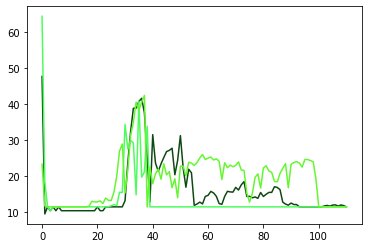

ROUND 110
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299900
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302035
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329254
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286091
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.281487

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304156
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311637
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313848
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.259903
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291354

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301334
Model client8 Train Epoch: 2 [0/12

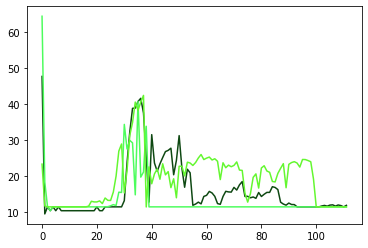

ROUND 111
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307124
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322215
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306986
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351758
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336843

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304226
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311980
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331269
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335103
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333021

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301480
Model client8 Train Epoch: 2 [0/12

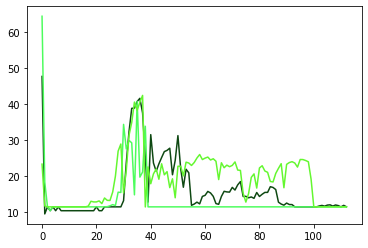

ROUND 112
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302442
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287793
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291805
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313211
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302745

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296860
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.345767
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328642
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.278482
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289982

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300240
Model client8 Train Epoch: 2 [0/12

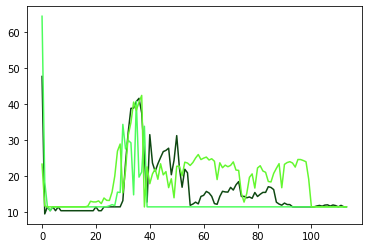

ROUND 113
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295685
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294847
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329875
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314127
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314199

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304096
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313599
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306697
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302939
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.352053

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304378
Model client8 Train Epoch: 2 [0/12

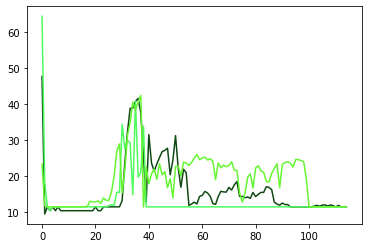

ROUND 114
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296695
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303007
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317634
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.269380
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297138

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311646
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325083
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323766
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330984
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.335153

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304343
Model client8 Train Epoch: 2 [0/12

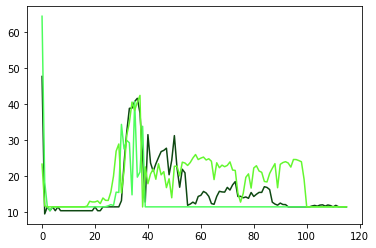

ROUND 115
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301059
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310166
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314540
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287447
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305110

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301686
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.258173
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310698
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.300336
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326527

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307807
Model client8 Train Epoch: 2 [0/12

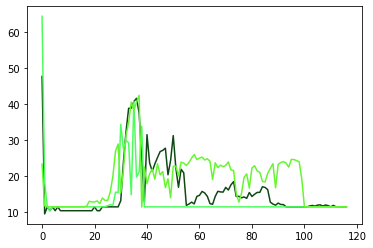

ROUND 116
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295507
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312713
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.309284
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311447
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273145

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292589
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322165
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.359552
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310253
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312428

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307817
Model client8 Train Epoch: 2 [0/12

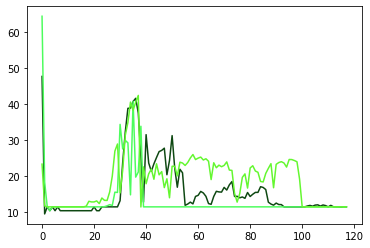

ROUND 117
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295558
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314927
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327803
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297247
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303645

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303767
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290612
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306306
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321871
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326737

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299229
Model client8 Train Epoch: 2 [0/12

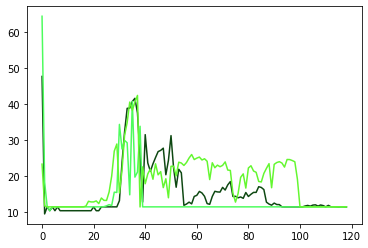

ROUND 118
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297207
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290912
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310213
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364786
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.334120

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297507
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.325655
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292838
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.335357
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286613

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309559
Model client8 Train Epoch: 2 [0/12

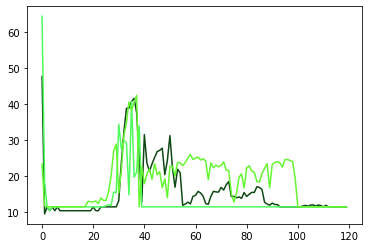

ROUND 119
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294086
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311342
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308974
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.276407
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317161

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309465
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.332925
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327865
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311815
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327446

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299236
Model client8 Train Epoch: 2 [0/12

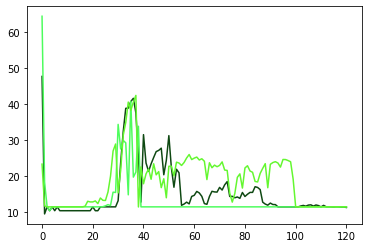

ROUND 120
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299767
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308880
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334578
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307492
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293750

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306074
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300905
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.354706
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340529
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300817

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304432
Model client8 Train Epoch: 2 [0/12

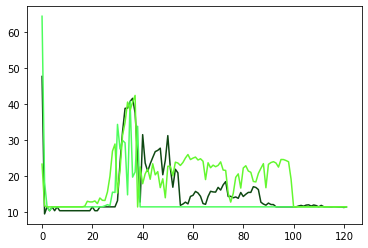

ROUND 121
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304031
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301381
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325625
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.290214
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319190

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302710
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308455
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360994
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.272902
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289948

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297888
Model client8 Train Epoch: 2 [0/12

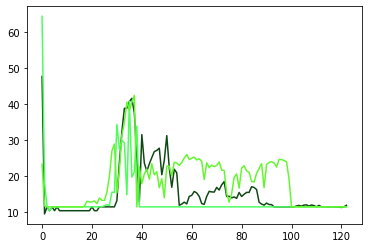

ROUND 122
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304667
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308331
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313223
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.375423
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315124

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301263
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296736
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316206
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311735
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267239

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304295
Model client8 Train Epoch: 2 [0/12

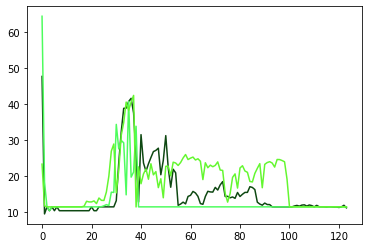

ROUND 123
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298221
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300005
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305125
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308090
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288528

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297753
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317877
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326657
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.369496
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299256

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300729
Model client8 Train Epoch: 2 [0/12

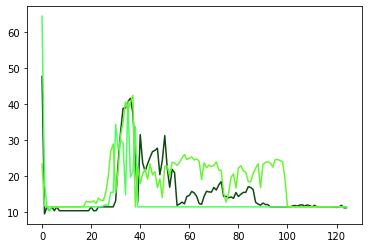

ROUND 124
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296607
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317979
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325166
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325577
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.271884

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302042
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.323746
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331787
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338088
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337553

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304483
Model client8 Train Epoch: 2 [0/12

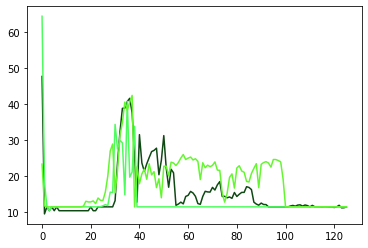

ROUND 125
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297676
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297513
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298188
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352143
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301102

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299939
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294112
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.351727
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324884
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.262071

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309003
Model client8 Train Epoch: 2 [0/12

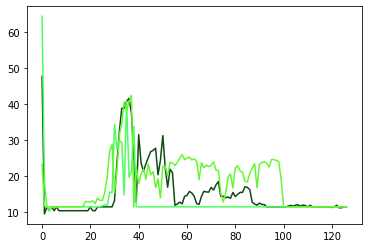

ROUND 126
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298022
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.282608
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293671
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297351
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299344

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300440
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.329707
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.355464
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.279661
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282535

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302278
Model client8 Train Epoch: 2 [0/12

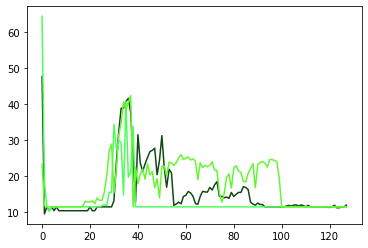

ROUND 127
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300392
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305815
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310425
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319472
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313083

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303376
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312790
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.332483
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314608
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297862

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309975
Model client8 Train Epoch: 2 [0/12

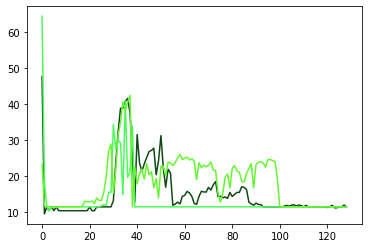

ROUND 128
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299334
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300324
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306378
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289115
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.272365

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306445
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.346218
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336559
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.265013
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.263314

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307569
Model client8 Train Epoch: 2 [0/12

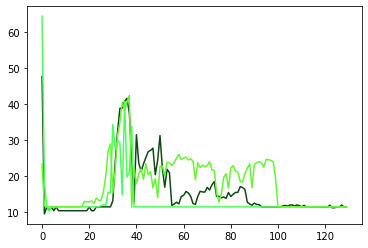

ROUND 129
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301816
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319601
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327314
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308006
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310869

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297584
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.342222
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353807
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281852
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301459

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305415
Model client8 Train Epoch: 2 [0/12

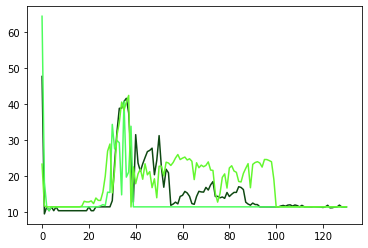

ROUND 130
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309433
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286772
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338118
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.294516
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329593

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294196
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.307405
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338150
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310148
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315151

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.311853
Model client8 Train Epoch: 2 [0/12

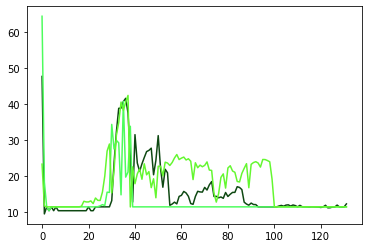

ROUND 131
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299683
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.319978
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.307438
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334420
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293549

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308042
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295332
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.379027
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280401
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276098

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308789
Model client8 Train Epoch: 2 [0/12

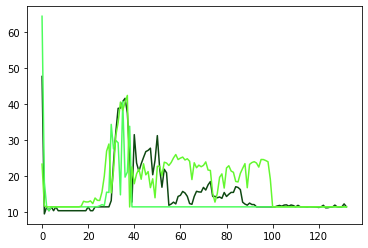

ROUND 132
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291166
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288345
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299088
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.297939
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328901

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303732
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317848
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.374927
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307442
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.265276

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309597
Model client8 Train Epoch: 2 [0/12

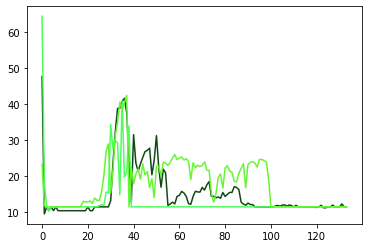

ROUND 133
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298250
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306021
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325813
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303653
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.255367

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301715
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289301
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345564
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328031
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.268653

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299483
Model client8 Train Epoch: 2 [0/12

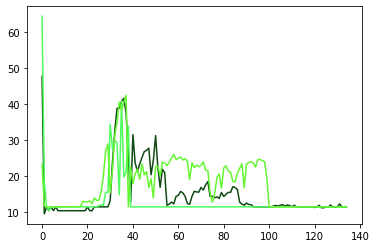

ROUND 134
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293087
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274397
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.304696
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352328
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.262814

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301152
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304398
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.404318
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288244
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317149

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309826
Model client8 Train Epoch: 2 [0/12

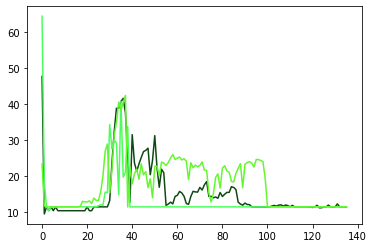

ROUND 135
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306061
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313498
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298984
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304126
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316698

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294600
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322163
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.367215
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303210
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.375619

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308600
Model client8 Train Epoch: 2 [0/12

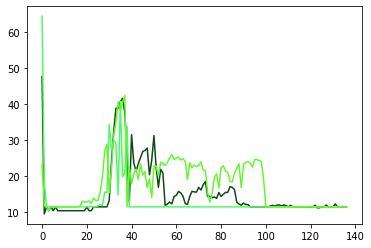

ROUND 136
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302985
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297841
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302012
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.377557
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288901

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302062
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.340401
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.379582
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299436
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.315399

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300514
Model client8 Train Epoch: 2 [0/12

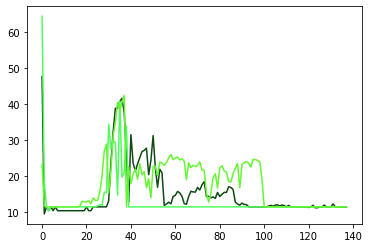

ROUND 137
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293357
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299785
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303390
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.309258
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310347

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304773
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335264
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.360375
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302356
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306558

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299844
Model client8 Train Epoch: 2 [0/12

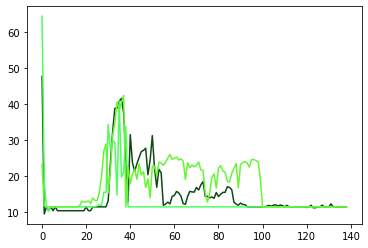

ROUND 138
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302035
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308312
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322352
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306966
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323905

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294361
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.337082
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314206
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.352402
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314087

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308393
Model client8 Train Epoch: 2 [0/12

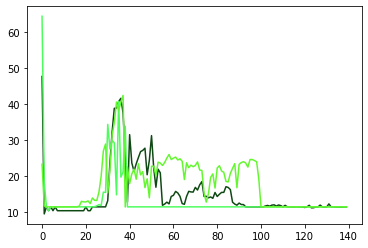

ROUND 139
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304307
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296947
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330412
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310209
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296991

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299405
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.248832
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283772
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307112
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294903

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297057
Model client8 Train Epoch: 2 [0/12

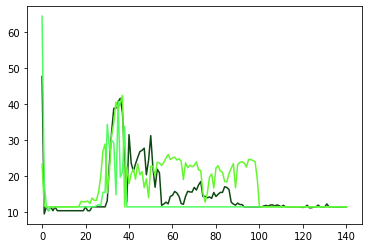

ROUND 140
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302840
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287358
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285240
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.243376
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320584

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301011
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311999
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.336115
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.283811
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337650

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305045
Model client8 Train Epoch: 2 [0/12

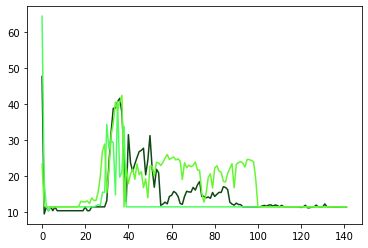

ROUND 141
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300627
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303326
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314289
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316063
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.300594

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308972
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.280393
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291684
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.267529
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.348545

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299166
Model client8 Train Epoch: 2 [0/12

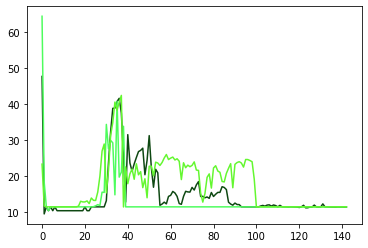

ROUND 142
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307347
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306617
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298621
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337475
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325618

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305639
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.360745
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391861
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350157
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299372

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294047
Model client8 Train Epoch: 2 [0/12

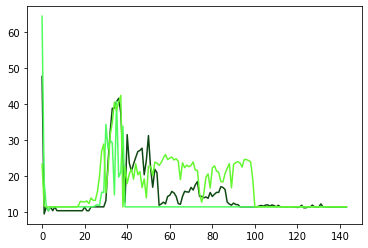

ROUND 143
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303608
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.290443
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331127
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.336126
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312853

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298959
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320045
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295225
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333615
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.254055

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299771
Model client8 Train Epoch: 2 [0/12

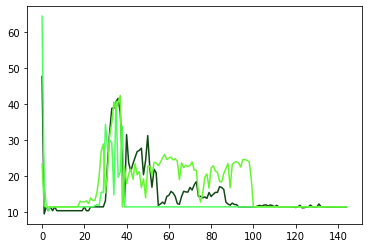

ROUND 144
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295089
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297324
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305828
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365353
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.302372

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301406
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328915
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.376678
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366489
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316025

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296492
Model client8 Train Epoch: 2 [0/12

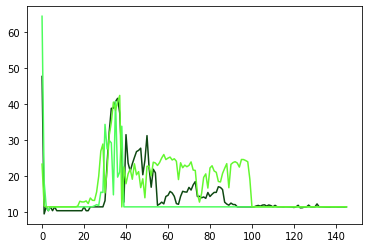

ROUND 145
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303526
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.334123
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312496
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.358018
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293916

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301793
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306534
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.279011
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333469
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286046

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294963
Model client8 Train Epoch: 2 [0/12

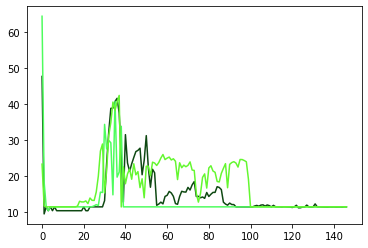

ROUND 146
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.291842
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295797
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372996
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311593
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.277812

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307275
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.357362
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.333316
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330394
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292308

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304866
Model client8 Train Epoch: 2 [0/12

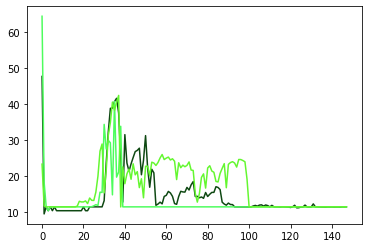

ROUND 147
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296082
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.305249
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300975
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325040
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.286540

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303160
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309805
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303768
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.299277
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.317186

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306828
Model client8 Train Epoch: 2 [0/12

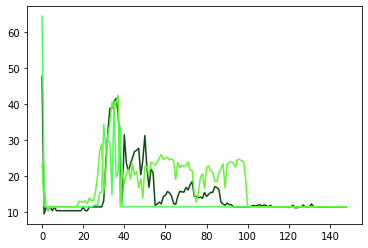

ROUND 148
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292937
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.335700
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295097
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.319069
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328389

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299745
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300341
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301351
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296927
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296157

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302612
Model client8 Train Epoch: 2 [0/12

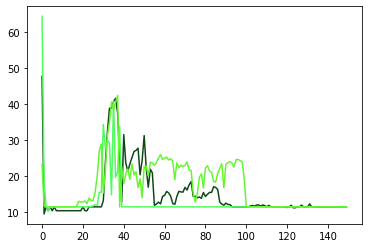

ROUND 149
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296304
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314309
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.339931
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356596
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.290399

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301947
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.338347
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350992
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.372525
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322051

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305850
Model client8 Train Epoch: 2 [0/12

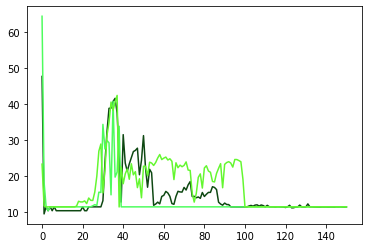

ROUND 150
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300905
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286001
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285592
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.345649
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305523

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297461
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295332
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292230
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343189
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340273

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305385
Model client8 Train Epoch: 2 [0/12

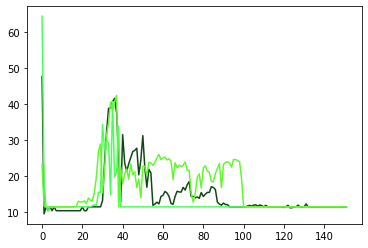

ROUND 151
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308290
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300732
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291984
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361698
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.288033

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297612
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308881
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326502
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286764
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.337626

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298727
Model client8 Train Epoch: 2 [0/12

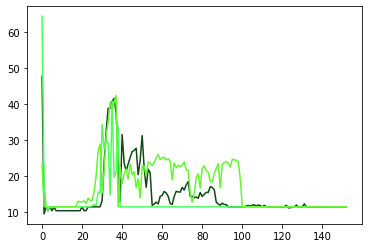

ROUND 152
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299803
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301523
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.301288
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298135
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311219

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.293860
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.324999
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314884
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.278636
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.329878

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303234
Model client8 Train Epoch: 2 [0/12

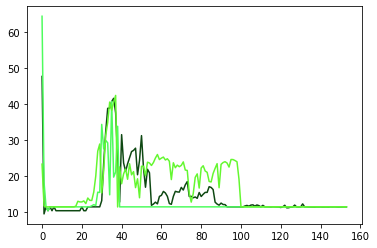

ROUND 153
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295377
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286904
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316632
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.328492
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267861

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295424
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278492
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285772
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.353859
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.269786

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301314
Model client8 Train Epoch: 2 [0/12

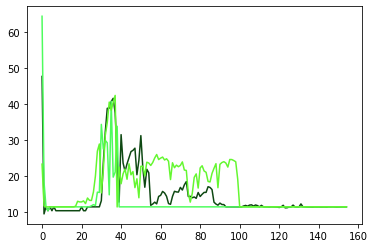

ROUND 154
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305598
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313644
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308806
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.350504
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.311044

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302524
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300737
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.340943
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.361135
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303357

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303383
Model client8 Train Epoch: 2 [0/12

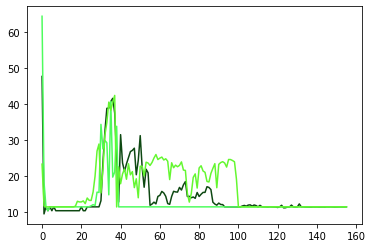

ROUND 155
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292486
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.308212
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311504
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.287812
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.318175

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298337
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303233
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293470
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.293089
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320042

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302705
Model client8 Train Epoch: 2 [0/12

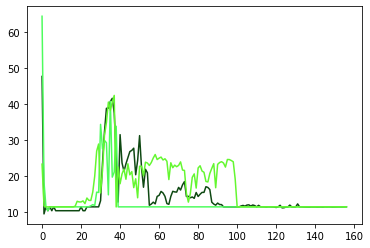

ROUND 156
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294632
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295866
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.324954
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303749
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301766

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308415
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.254571
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350926
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.364145
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299203

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308862
Model client8 Train Epoch: 2 [0/12

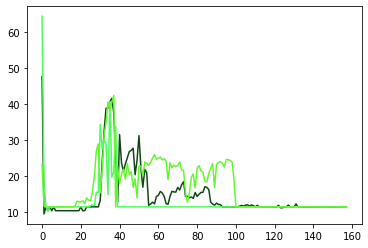

ROUND 157
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296202
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311799
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291094
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.276556
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292183

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303096
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275392
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.287529
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.334487
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.338138

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304837
Model client8 Train Epoch: 2 [0/12

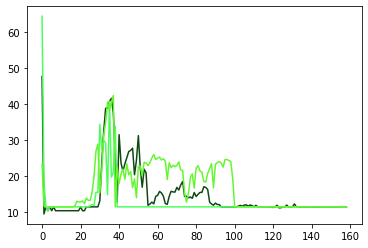

ROUND 158
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309767
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304857
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.303709
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289871
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.269701

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302518
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.317830
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350874
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343024
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.240832

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304779
Model client8 Train Epoch: 2 [0/12

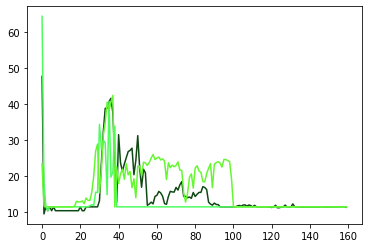

ROUND 159
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298100
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295148
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306446
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.325141
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.336134

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306716
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.327141
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.350261
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327928
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324136

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302271
Model client8 Train Epoch: 2 [0/12

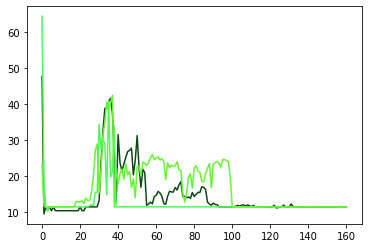

ROUND 160
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303948
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300211
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.320659
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340161
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328753

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300510
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288148
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327614
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.383596
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289652

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309274
Model client8 Train Epoch: 2 [0/12

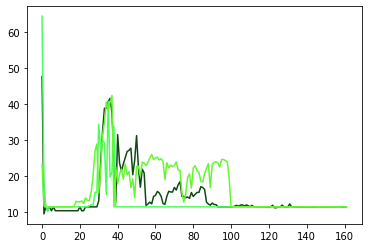

ROUND 161
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301105
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311651
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314974
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.308341
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.260826

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304762
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266137
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349981
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.252387
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322010

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302330
Model client8 Train Epoch: 2 [0/12

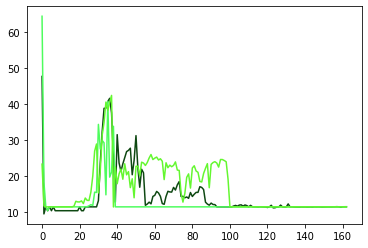

ROUND 162
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298243
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299744
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308563
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.337770
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327542

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295016
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.286415
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.349882
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347827
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.323433

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307992
Model client8 Train Epoch: 2 [0/12

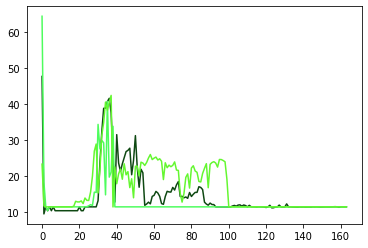

ROUND 163
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296063
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296338
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331169
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.311936
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.327672

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309249
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.352894
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283163
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.374771
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357030

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305133
Model client8 Train Epoch: 2 [0/12

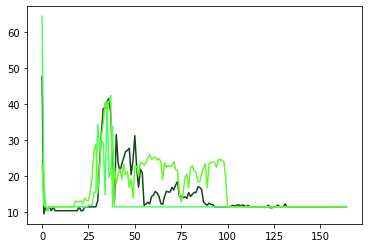

ROUND 164
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297256
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285894
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290900
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324459
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.289629

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301092
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.267610
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.378635
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.351719
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287596

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295851
Model client8 Train Epoch: 2 [0/12

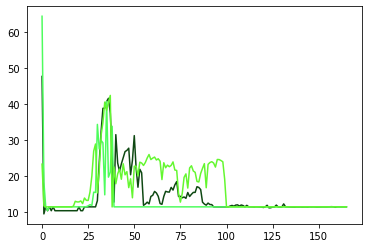

ROUND 165
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302516
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314095
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294241
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312634
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.296058

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300671
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295897
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.280067
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318582
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293060

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303659
Model client8 Train Epoch: 2 [0/12

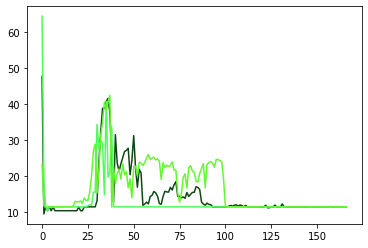

ROUND 166
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298357
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292973
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.325459
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.317993
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.308877

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307550
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.245983
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316593
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.365643
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.322556

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302423
Model client8 Train Epoch: 2 [0/12

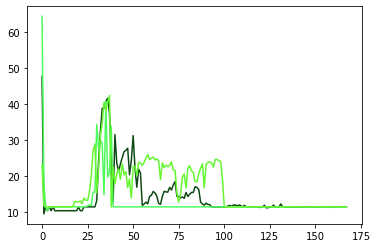

ROUND 167
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302563
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297210
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.334315
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.298832
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.303919

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301329
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300751
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.272942
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366471
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.268566

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298175
Model client8 Train Epoch: 2 [0/12

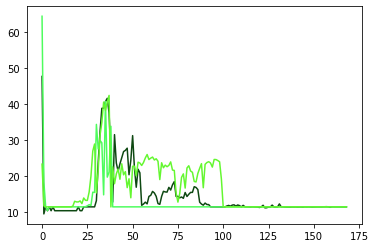

ROUND 168
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305018
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320322
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293644
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333117
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.291764

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.289972
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.284457
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.341005
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.378055
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.355650

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306378
Model client8 Train Epoch: 2 [0/12

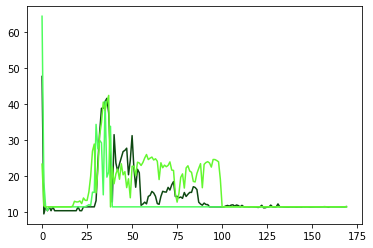

ROUND 169
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301484
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.320555
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318217
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.342027
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.274476

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296262
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.289289
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.294737
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.226503
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316411

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308708
Model client8 Train Epoch: 2 [0/12

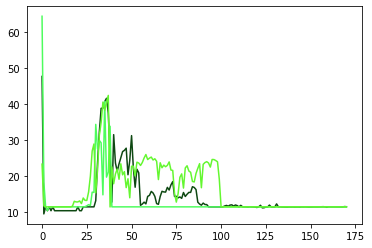

ROUND 170
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298374
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301448
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312367
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.323051
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316199

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310730
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.259361
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.338547
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286821
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.294950

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303212
Model client8 Train Epoch: 2 [0/12

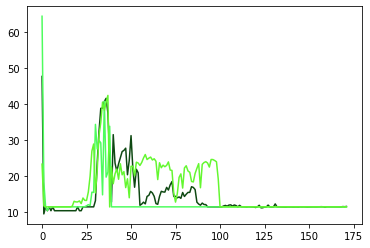

ROUND 171
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304046
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.315366
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295712
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316673
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.333650

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302659
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.277840
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353239
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318995
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.276917

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304774
Model client8 Train Epoch: 2 [0/12

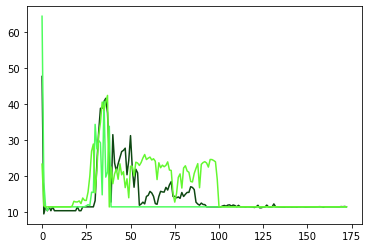

ROUND 172
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302326
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300477
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.274889
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.306941
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.268860

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300705
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.312825
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.329125
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.339454
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.331204

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301618
Model client8 Train Epoch: 2 [0/12

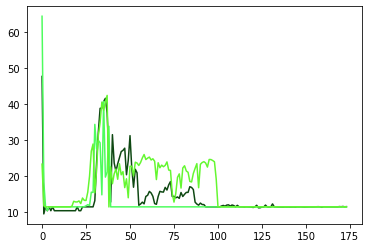

ROUND 173
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303099
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294696
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321126
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340216
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.316348

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305996
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276490
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317678
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.366947
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306607

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305474
Model client8 Train Epoch: 2 [0/12

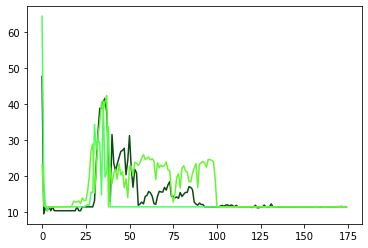

ROUND 174
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298369
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293884
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330308
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.288267
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304725

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300017
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303838
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347204
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.340774
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.340289

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297172
Model client8 Train Epoch: 2 [0/12

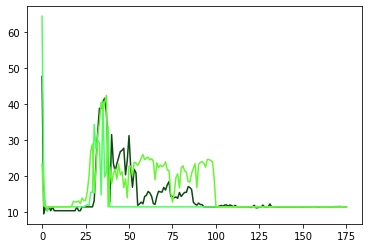

ROUND 175
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304894
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310152
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317482
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.304976
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.279611

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305965
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.269264
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326848
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.272854
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306880

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305921
Model client8 Train Epoch: 2 [0/12

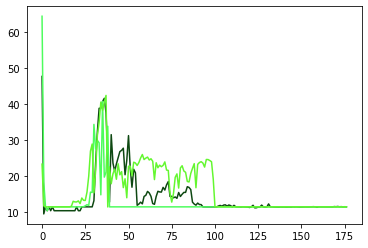

ROUND 176
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307941
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300584
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.288811
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.289108
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.362244

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309354
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298326
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302356
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.347980
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.285154

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308681
Model client8 Train Epoch: 2 [0/12

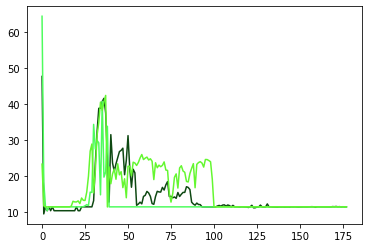

ROUND 177
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298821
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.314515
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.331982
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.292377
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295409

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298683
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295496
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.330082
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367414
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297098

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305318
Model client8 Train Epoch: 2 [0/12

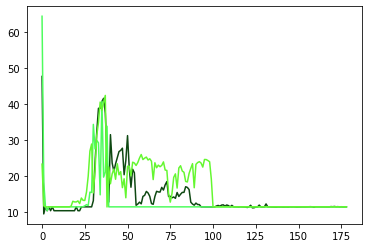

ROUND 178
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302618
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311945
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.305483
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.329282
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309313

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306993
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300072
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326296
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.343206
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.328687

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301831
Model client8 Train Epoch: 2 [0/12

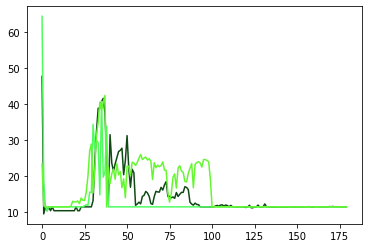

ROUND 179
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302311
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288466
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291097
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.321903
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312548

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303439
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278511
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313423
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.275217
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.301538

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303796
Model client8 Train Epoch: 2 [0/12

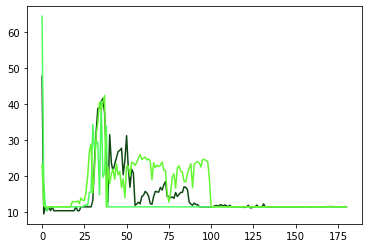

ROUND 180
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297766
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295768
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293783
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327059
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.324991

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301243
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328112
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312584
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.303853
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.353335

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298300
Model client8 Train Epoch: 2 [0/12

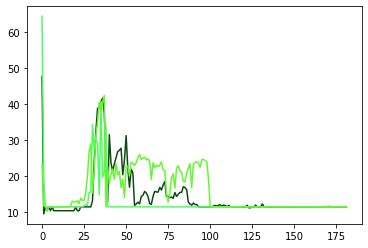

ROUND 181
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297243
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300870
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312799
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.307217
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319606

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303650
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.231311
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.316671
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.367988
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280659

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303208
Model client8 Train Epoch: 2 [0/12

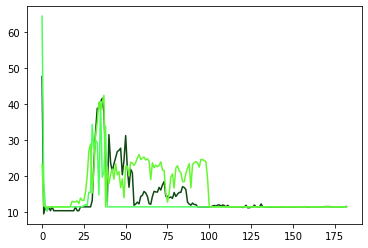

ROUND 182
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309164
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299828
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.335215
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.291781
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.275748

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299683
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.301106
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.391097
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.282479
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.313858

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303658
Model client8 Train Epoch: 2 [0/12

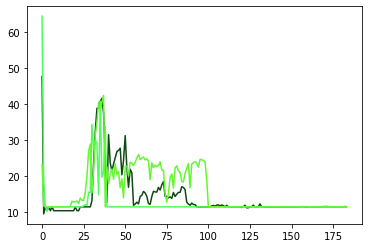

ROUND 183
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303119
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318832
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291630
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.284029
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.287306

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303705
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278605
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308807
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296709
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326778

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298174
Model client8 Train Epoch: 2 [0/12

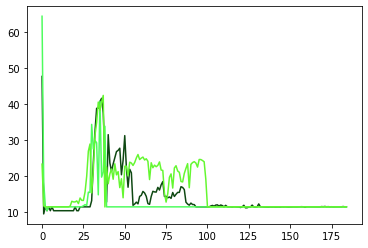

ROUND 184
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301696
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304007
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318966
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.286775
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273461

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294773
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272708
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.357655
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.368446
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.325796

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312074
Model client8 Train Epoch: 2 [0/12

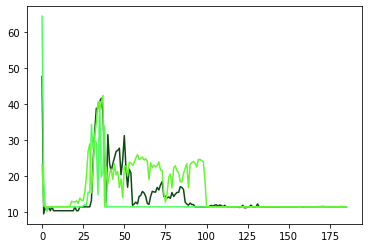

ROUND 185
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300204
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298469
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.296442
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330597
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.312582

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302637
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275301
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.317740
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357156
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309457

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298331
Model client8 Train Epoch: 2 [0/12

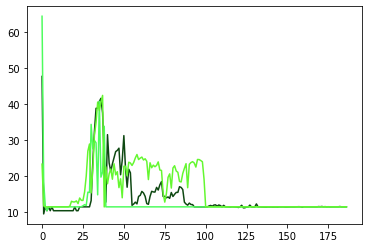

ROUND 186
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304444
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.288224
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.267266
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.324325
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.297611

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294589
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.216499
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.318324
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.360690
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.354397

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.312294
Model client8 Train Epoch: 2 [0/12

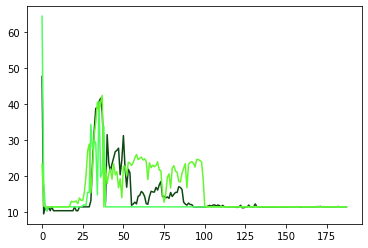

ROUND 187
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301253
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291668
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313413
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.271978
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310627

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305755
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.339278
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281393
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.356063
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.273296

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306531
Model client8 Train Epoch: 2 [0/12

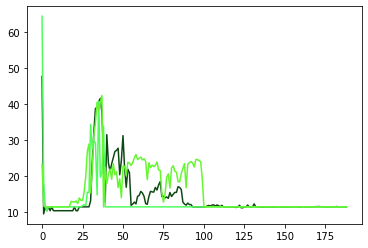

ROUND 188
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299946
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293954
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.308107
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.270995
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.344306

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294119
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279106
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.275070
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.316973
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.320628

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302411
Model client8 Train Epoch: 2 [0/12

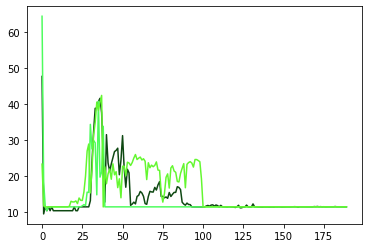

ROUND 189
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301678
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310556
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.292531
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.302558
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310577

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296358
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.349703
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.326707
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338235
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.326578

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308180
Model client8 Train Epoch: 2 [0/12

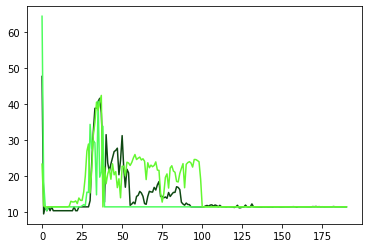

ROUND 190
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.308239
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295406
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293643
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.260765
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.293638

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303951
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.322551
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.313246
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.346011
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.298330

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301783
Model client8 Train Epoch: 2 [0/12

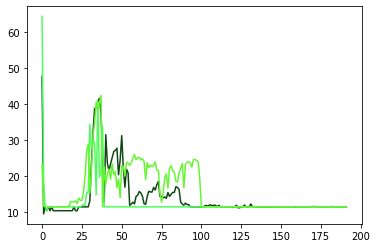

ROUND 191
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297491
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.306065
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.312227
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.296026
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.319625

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304363
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291797
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.327944
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.348417
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310263

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300568
Model client8 Train Epoch: 2 [0/12

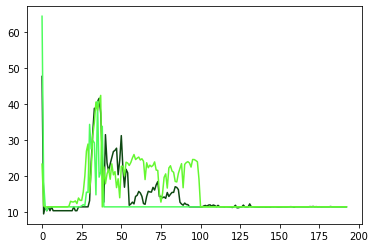

ROUND 192
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301570
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292900
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.347342
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.318864
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.299194

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303667
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313240
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.322806
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.327366
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.305789

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303661
Model client8 Train Epoch: 2 [0/12

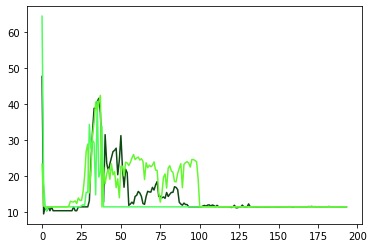

ROUND 193
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298050
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291135
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.328710
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.330908
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.314569

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299823
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292156
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.392718
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.357854
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.309640

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306108
Model client8 Train Epoch: 2 [0/12

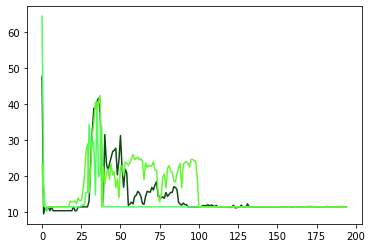

ROUND 194
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296504
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297470
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.311963
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.285903
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292974

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295663
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.239082
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285557
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.313476
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.295524

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307845
Model client8 Train Epoch: 2 [0/12

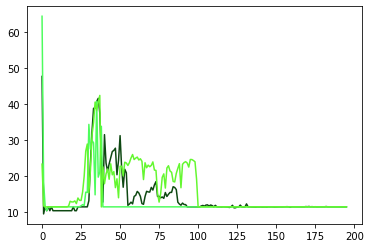

ROUND 195
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305037
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.309530
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.314122
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.312368
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.310395

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300581
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.311793
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.297745
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.354162
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.292648

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297971
Model client8 Train Epoch: 2 [0/12

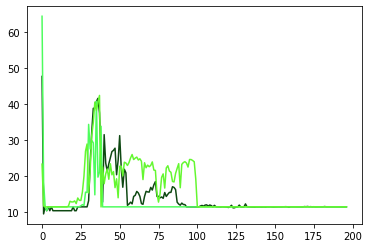

ROUND 196
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306994
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292733
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.310031
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.338359
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.304631

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301834
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.303099
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283541
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.295592
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.267157

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310782
Model client8 Train Epoch: 2 [0/12

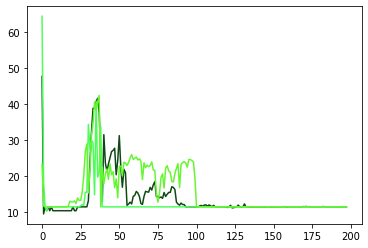

ROUND 197
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304679
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.302402
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.293024
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.310627
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.306678

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302163
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.223181
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291537
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.349231
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.238183

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304330
Model client8 Train Epoch: 2 [0/12

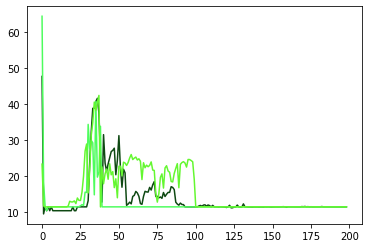

ROUND 198
0.15306000000000705
Power Allocated= 0.30478551018017175
CSI= 0.16054971992299527
SNR= 19.560577210789415
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300963
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291423
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.306771
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.280595
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.282691

Power Allocated= 4.399185631283983
CSI= 0.46855965441975056
SNR= 34.01912159599754
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301231
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.162510
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.368283
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.333554
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.349745

Power Allocated= 4.113924085802212
CSI= 0.413315109151
SNR= 24.420823315017593
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303410
Model client8 Train Epoch: 2 [0/12

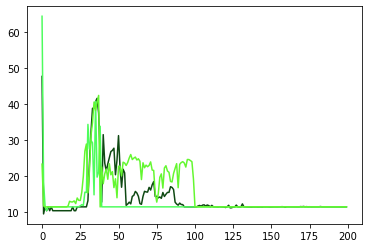

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]   
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[47.58, 64.3, 23.22], [9.39, 18.22, 11.62], [11.35, 11.39, 11.35], [10.28, 10.28, 11.35], [11.35, 11.35, 11.35], [10.28, 11.35, 11.35], [11.35, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.35], [10.28, 11.35, 11.55], [10.28, 11.35, 12.9], [10.28, 11.35, 12.72], [11.35, 11.35, 12.72], [10.28, 11.35, 13.0], [10.28, 11.35, 12.26], [11.35, 11.35, 13.81], [11.35, 11.4, 13.16], [11.35, 11.64, 13.13], [11.35, 11.97, 15.48], [11.35, 11.72, 19.89], [11.35, 15.43, 26.84], [11.35, 15.35, 28.81], [13.07, 34.26, 15.23], [23.62, 27.44, 21.5], [32.2, 29.81, 31.22], [38.72, 29.14, 34.77], [38.78, 14.69, 40.46], [40.62, 40.67, 38.16], [41.5, 19.61, 40.43], [37.43, 21.03, 42.31], [25.05, 33.74, 11.32], [12.68, 11.35, 22.45], [31.41, 11.35, 17.77], [23.53, 11.35, 20.51], [21.23, 11.35, 21.87], [23.3, 11.35, 19.0